In [2]:
%matplotlib inline

In [3]:
%run setup_environment.py
%run custom_tools.py
%run ml_tools.py

current_conda_env = !echo $CONDA_DEFAULT_ENV
check_conda_env(current_conda_env[0])

Setup environment... done!


✅ <span style='color:green'>Working on **impact-annotator_env** conda environment.</span>

In [4]:
import sys
sys.path.append('/Users/pierreguilmin/anaconda3/envs/impact-annotator_env/lib/python3.6/site-packages')

In [5]:
import sys
sys.path

['',
 '/Users/pierreguilmin/anaconda3/lib/python36.zip',
 '/Users/pierreguilmin/anaconda3/lib/python3.6',
 '/Users/pierreguilmin/anaconda3/lib/python3.6/lib-dynload',
 '/Users/pierreguilmin/.local/lib/python3.6/site-packages',
 '/Users/pierreguilmin/anaconda3/lib/python3.6/site-packages',
 '/Users/pierreguilmin/anaconda3/lib/python3.6/site-packages/aeosa',
 '/Users/pierreguilmin/anaconda3/lib/python3.6/site-packages/IPython/extensions',
 '/Users/pierreguilmin/.ipython',
 '/Users/pierreguilmin/anaconda3/envs/impact-annotator_env/lib/python3.6/site-packages']

In [6]:
!which python
!which ipython

/Users/pierreguilmin/anaconda3/envs/impact-annotator_env/bin/python
/Users/pierreguilmin/anaconda3/envs/impact-annotator_env/bin/ipython


# somatic vs non-somatic classification

In [10]:
impact = pd.read_csv('../../data/annotated_final_IMPACT_mutations_180508.txt', sep = '\t', low_memory = False)

# shuffle data
rng = np.random.RandomState(0)
permutation = rng.permutation(len(impact))
impact = impact.iloc[permutation]

impact.shape

(194211, 63)

## Feature processsing

### `is_somatic`

In [11]:
get_table(impact.confidence_class)

,count_,freq_
AUTO_OK,180832,93.1%
UNLIKELY,7199,3.7%
MANUAL_OK,6180,3.2%


In [12]:
impact['is_somatic'] = impact.confidence_class != "UNLIKELY"
get_table(impact.is_somatic)

,count_,freq_
True,187012,96.3%
False,7199,3.7%


## Setup the train/test sets

In [13]:
label_feature_name = 'is_somatic'

In [14]:
print(impact[~impact.is_somatic].shape)
print(impact[impact.is_somatic].iloc[0:20000].shape)

impact_selected = pd.concat([impact[~impact.is_somatic],
                             impact[impact.is_somatic].iloc[0:20000]], ignore_index = True)

impact_selected.shape

(7199, 64)
(20000, 64)


(27199, 64)

### Choose features

In [15]:
feature_names = [
# 'Hugo_Symbol', 'Chromosome', 'Start_Position', 'End_Position', 'Consequence', 'Variant_Type', 'Reference_Allele', 'Tumor_Seq_Allele2', 'Tumor_Sample_Barcode',
# 'cDNA_change', 'HGVSp_Short',
't_depth', 't_vaf', 't_alt_count', 'n_depth', 'n_vaf', 'n_alt_count',
# 't_ref_plus_count', 't_ref_neg_count', 't_alt_plus_count', 't_alt_neg_count',
#'confidence_class',
'sample_coverage',
#'mut_key',
#'VAG_VT', 'VAG_GENE', 'VAG_cDNA_CHANGE', 'VAG_PROTEIN_CHANGE', 'VAG_EFFECT',
'VEP_Consequence',
#'VEP_SYMBOL', 'VEP_HGVSc', 'VEP_HGVSp',
#'VEP_Amino_acids',
'VEP_VARIANT_CLASS',
#'VEP_EXON', 'VEP_INTRON',
'VEP_IMPACT',
'VEP_CLIN_SIG',
'VEP_COSMIC_CNT',
'VEP_gnomAD_AF',
#'sample_mut_key', 'patient_key',
'frequency_in_normals',
#'VEP_SIFT_class',
#'VEP_SIFT_score',
#'VEP_PolyPhen_class',
#'VEP_PolyPhen_score',
'VEP_in_dbSNP',
'VEP_gnomAD_total_AF_AFR',
'VEP_gnomAD_total_AF_AMR',
'VEP_gnomAD_total_AF_ASJ',
'VEP_gnomAD_total_AF_EAS',
'VEP_gnomAD_total_AF_FIN',
'VEP_gnomAD_total_AF_NFE',
'VEP_gnomAD_total_AF_OTH',
'VEP_gnomAD_total_AF_max',
'VEP_gnomAD_total_AF',
'Kaviar_AF',
#'is_a_hotspot',
#'is_a_3d_hotspot',
#'oncogenic',
'gene_type',
label_feature_name
]

categorical_features_names = [
'VEP_Consequence',
#'VEP_Amino_acids',
'VEP_VARIANT_CLASS',
'VEP_IMPACT',
'VEP_CLIN_SIG',
#'VEP_SIFT_class',
#'VEP_PolyPhen_class',
'VEP_in_dbSNP',
'gene_type',
]

In [16]:
impact_selected = impact_selected[feature_names].dropna()
impact_selected.shape

(27199, 27)

In [17]:
impact_selected = pd.get_dummies(impact_selected, columns = categorical_features_names, sparse = True)
impact_selected.shape

(27199, 46)

### Split features from label

In [18]:
X = impact_selected.drop(label_feature_name, axis = 1) # features matrix X: [n_samples, n_features]
y = impact_selected[label_feature_name]                # target array y: n_samples
print(X.shape)
print(y.shape)

(27199, 45)
(27199,)


In [19]:
get_table(y)

,count_,freq_
True,20000,73.5%
False,7199,26.5%


## Main functions

In [21]:
from sklearn.model_selection import StratifiedShuffleSplit

# returns stratified randomized folds. The folds are made by preserving the percentage of samples for each class.
cv_strategy = StratifiedShuffleSplit(n_splits = 5, test_size = 0.2, random_state = 1)

In [17]:
from sklearn.model_selection import GridSearchCV

# inner cross validation on hyperparameters
inner_cv_strategy = StratifiedShuffleSplit(n_splits = 3, test_size = 0.2, random_state = 1)

In [18]:
i = 0
for train_index, test_index in cv_strategy.split(X, y):
    print("Fold %d :\n" % i,
          "  → train_index (%5d elements) %s\n" % (len(train_index), str(train_index)),
          "  → test_index  (%5d elements) %s" % (len(test_index), str(test_index)))
    i += 1

Fold 0 :
   → train_index (21759 elements) [22384  9014  2951 ... 12325  1992 23421]
   → test_index  ( 5440 elements) [25681   326  3615 ...  8464 16587 15818]
Fold 1 :
   → train_index (21759 elements) [ 8628 18579  1037 ... 20352  6647 17410]
   → test_index  ( 5440 elements) [20063 12561 14191 ...  4164   710 20468]
Fold 2 :
   → train_index (21759 elements) [ 1441 21283 25746 ... 17064 10776  1673]
   → test_index  ( 5440 elements) [ 7412 17231 19251 ... 23327 12897  1196]
Fold 3 :
   → train_index (21759 elements) [16914 18024 19701 ...  7224 10318 20742]
   → test_index  ( 5440 elements) [  480  6279 17232 ...  6841 17050  9946]
Fold 4 :
   → train_index (21759 elements) [  141  3724  7643 ...  9259 10806 12796]
   → test_index  ( 5440 elements) [23573 25413 16572 ... 21823  5713  2985]


## Dummy

### Uniform


## Mean accuracy: 0.50 ± 0.01
## Mean ROC AUC : 0.50 ± 0.00


,fit_time,score_time,train_accuracy,test_accuracy,train_roc_auc,test_roc_auc,best_parameters
fold_number,,,,,,,
0,0.028085,0.0154431,0.499242,0.50625,0.5,0.5,NaN
1,0.0166409,0.0143769,0.499885,0.49375,0.5,0.5,NaN
2,0.0181172,0.015445,0.499058,0.502206,0.5,0.5,NaN
3,0.0161719,0.0146649,0.496852,0.49375,0.5,0.5,NaN
4,0.0177619,0.0153129,0.502275,0.494118,0.5,0.5,NaN


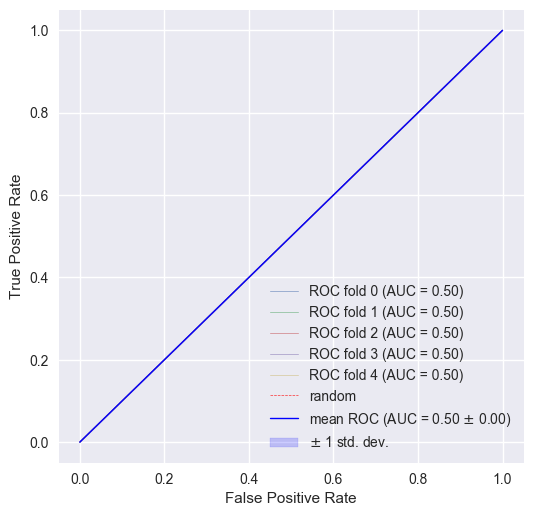

In [19]:
from sklearn.dummy import DummyClassifier

model_uniform = DummyClassifier(strategy = 'uniform', random_state = 1)
# generates predictions uniformly at random
#   → expected accuracy: 0.5 | expected AUC: 0.5

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
run_model(model_uniform, X, y, cv_strategy, plot_roc = True, ax = ax)

### Most Frequent


## Mean accuracy: 0.74 ± 0.00
## Mean ROC AUC : 0.50 ± 0.00


,fit_time,score_time,train_accuracy,test_accuracy,train_roc_auc,test_roc_auc,best_parameters
fold_number,,,,,,,
0,0.0197401,0.0128272,0.735328,0.735294,0.5,0.5,NaN
1,0.0152552,0.014462,0.735328,0.735294,0.5,0.5,NaN
2,0.0221248,0.0230029,0.735328,0.735294,0.5,0.5,NaN
3,0.0172219,0.0177588,0.735328,0.735294,0.5,0.5,NaN
4,0.0174294,0.0159132,0.735328,0.735294,0.5,0.5,NaN


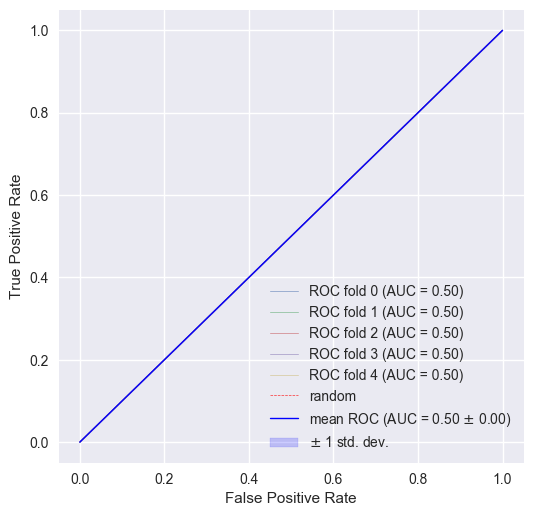

In [20]:
from sklearn.dummy import DummyClassifier

model_most_frequent = DummyClassifier(strategy = 'most_frequent', random_state = 1)
# always predicts the most frequent label in the training set
#   → expected accuracy: proportion of the most reccurent class in the dataset | expected AUC: 0.5

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
run_model(model_most_frequent, X, y, cv_strategy, plot_roc = True, ax = ax)

## Gaussian Naive Bayes


## Mean accuracy: 0.80 ± 0.01
## Mean ROC AUC : 0.80 ± 0.02


,fit_time,score_time,train_accuracy,test_accuracy,train_roc_auc,test_roc_auc,best_parameters
fold_number,,,,,,,
0,0.0869362,0.0450382,0.797739,0.799816,0.79922,0.788132,NaN
1,0.06653,0.0406449,0.795119,0.795404,0.798381,0.806598,NaN
2,0.120221,0.0685849,0.793511,0.79761,0.79502,0.799848,NaN
3,0.0894399,0.0523646,0.796498,0.800735,0.796747,0.793025,NaN
4,0.108671,0.0724111,0.79875,0.807169,0.798306,0.80942,NaN


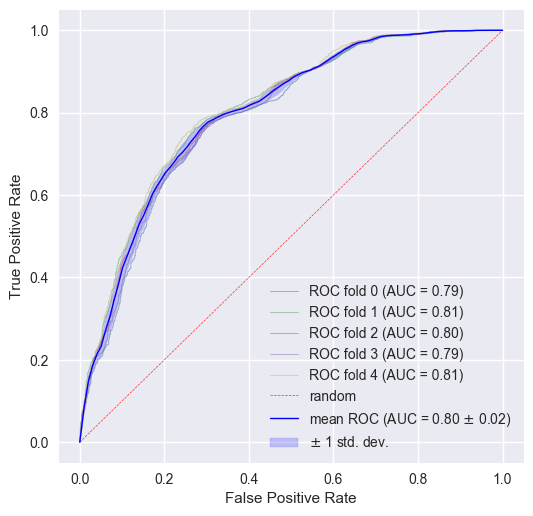

In [21]:
from sklearn.naive_bayes import GaussianNB

model_GaussianNB = GaussianNB()

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
run_model(model_GaussianNB, X, y, cv_strategy, plot_roc = True, ax = ax)

In [22]:
#from sklearn.naive_bayes import ComplementNB

#model_ComplementNB = ComplementNB()

#fig, ax = plt.subplots(1, 1, figsize = (6, 6))
#run(model_ComplementNB, X, y, cv_strategy, plot_roc = True, ax = ax)

## Logistic Regression


## Mean accuracy: 0.84 ± 0.01
## Mean ROC AUC : 0.83 ± 0.01


,fit_time,score_time,train_accuracy,test_accuracy,train_roc_auc,test_roc_auc,best_parameters
fold_number,,,,,,,
0,5.93844,0.018146,0.838504,0.839522,0.825661,0.819195,NaN
1,4.98763,0.0172701,0.837401,0.833272,0.822853,0.827173,NaN
2,4.21301,0.0179682,0.837401,0.844118,0.824009,0.825046,NaN
3,4.90267,0.0173311,0.838871,0.837316,0.825695,0.823652,NaN
4,5.15702,0.0172563,0.8357,0.844853,0.823005,0.834868,NaN


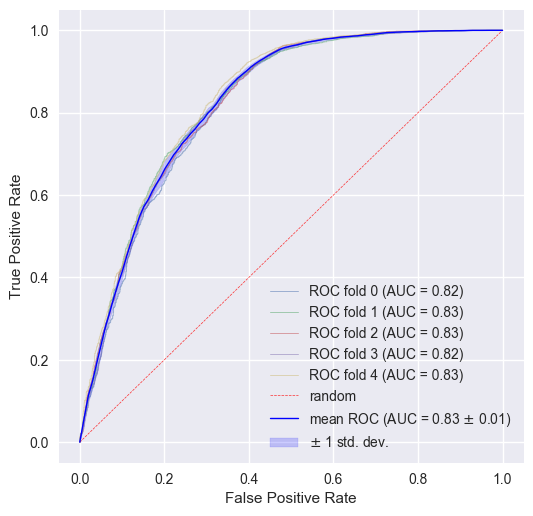

In [23]:
from sklearn.linear_model import LogisticRegressionCV

model_LogisticRegressionCV = LogisticRegressionCV(random_state = 1)
# Logistic Regression with builtin cross-validation to find out the optimal C parameter

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
run_model(model_LogisticRegressionCV, X, y, cv_strategy, plot_roc = True, ax = ax)

## K Nearest Neighbors

Fold #: [fit_time | score_time]
   → accuracy: [test_accuracy | train_accuracy]
   → ROC AUC : [test_roc_auc  | train_roc_auc]

Fold 0: [139.44s | 11.06s]
  → accuracy: [0.80 | 1.00]
  → ROC AUC : [0.81 | 1.00]
  → Best parameters : {'n_neighbors': 100, 'weights': 'distance'}
    0.77 ± 0.01 for {'n_neighbors': 10, 'weights': 'uniform'}
    0.78 ± 0.01 for {'n_neighbors': 10, 'weights': 'distance'}
    0.78 ± 0.02 for {'n_neighbors': 50, 'weights': 'uniform'}
    0.79 ± 0.01 for {'n_neighbors': 50, 'weights': 'distance'}
    0.78 ± 0.02 for {'n_neighbors': 100, 'weights': 'uniform'}
    0.79 ± 0.02 for {'n_neighbors': 100, 'weights': 'distance'}
Fold 1: [117.30s | 8.34s]
  → accuracy: [0.80 | 1.00]
  → ROC AUC : [0.80 | 1.00]
  → Best parameters : {'n_neighbors': 50, 'weights': 'distance'}
    0.76 ± 0.01 for {'n_neighbors': 10, 'weights': 'uniform'}
    0.78 ± 0.01 for {'n_neighbors': 10, 'weights': 'distance'}
    0.77 ± 0.01 for {'n_neighbors': 50, 'weights': 'uniform'}
    0.79 ± 0

,fit_time,score_time,train_accuracy,test_accuracy,train_roc_auc,test_roc_auc,best_parameters
fold_number,,,,,,,
0,139.437,11.0625,1,0.796691,1,0.805625,"{'n_neighbors': 100, 'weights': 'distance'}"
1,117.303,8.33732,1,0.803125,1,0.801449,"{'n_neighbors': 50, 'weights': 'distance'}"
2,112.266,8.60736,1,0.809191,1,0.797246,"{'n_neighbors': 50, 'weights': 'distance'}"
3,106.691,7.67954,1,0.808272,1,0.793599,"{'n_neighbors': 50, 'weights': 'distance'}"
4,117.185,7.93561,1,0.803676,1,0.79987,"{'n_neighbors': 50, 'weights': 'distance'}"


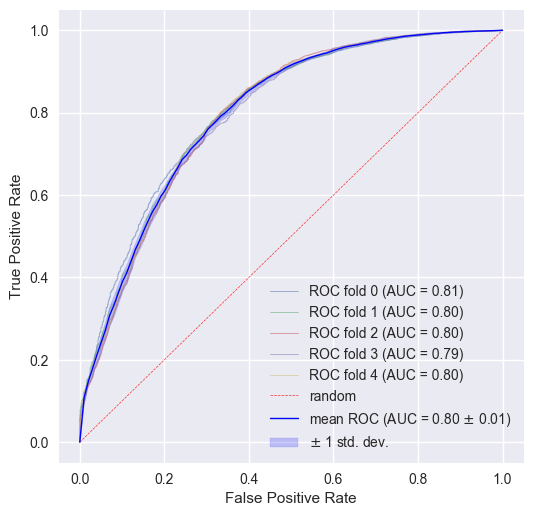

In [24]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

parameters_grid = [
    {'n_neighbors': [10, 50, 100], 'weights': ['uniform', 'distance']}
]

model_GS_KNeighborsClassifier = GridSearchCV(KNeighborsClassifier(), parameters_grid, cv = inner_cv_strategy, scoring = 'roc_auc', refit = True)

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
run_model(model_GS_KNeighborsClassifier, X, y, cv_strategy, grid_search = True, print_grid_search_metrics = True, print_fold_metrics = True, plot_roc = True, ax = ax)

## Random Forest

Fold #: [fit_time | score_time]
   → accuracy: [test_accuracy | train_accuracy]
   → ROC AUC : [test_roc_auc  | train_roc_auc]

Fold 0: [301.90s | 7.01s]
  → accuracy: [0.89 | 1.00]
  → ROC AUC : [0.89 | 1.00]
  → Best parameters : {'max_depth': 50, 'n_estimators': 1000}
    0.85 ± 0.01 for {'max_depth': 5, 'n_estimators': 10}
    0.86 ± 0.01 for {'max_depth': 5, 'n_estimators': 100}
    0.86 ± 0.00 for {'max_depth': 5, 'n_estimators': 1000}
    0.88 ± 0.00 for {'max_depth': 20, 'n_estimators': 10}
    0.89 ± 0.00 for {'max_depth': 20, 'n_estimators': 100}
    0.90 ± 0.00 for {'max_depth': 20, 'n_estimators': 1000}
    0.88 ± 0.01 for {'max_depth': 50, 'n_estimators': 10}
    0.89 ± 0.00 for {'max_depth': 50, 'n_estimators': 100}
    0.90 ± 0.00 for {'max_depth': 50, 'n_estimators': 1000}
Fold 1: [311.69s | 4.70s]
  → accuracy: [0.88 | 0.93]
  → ROC AUC : [0.90 | 0.96]
  → Best parameters : {'max_depth': 20, 'n_estimators': 1000}
    0.86 ± 0.01 for {'max_depth': 5, 'n_estimators': 10}

,fit_time,score_time,train_accuracy,test_accuracy,train_roc_auc,test_roc_auc,best_parameters
fold_number,,,,,,,
0,301.899,7.00568,1,0.8875,1,0.894499,"{'max_depth': 50, 'n_estimators': 1000}"
1,311.694,4.70313,0.928949,0.880331,0.964923,0.903131,"{'max_depth': 20, 'n_estimators': 1000}"
2,313.319,7.27124,0.928122,0.879963,0.965306,0.891553,"{'max_depth': 20, 'n_estimators': 1000}"
3,409.016,11.0728,1,0.884559,1,0.892541,"{'max_depth': 50, 'n_estimators': 1000}"
4,361.309,7.69033,1,0.887132,1,0.896806,"{'max_depth': 50, 'n_estimators': 1000}"


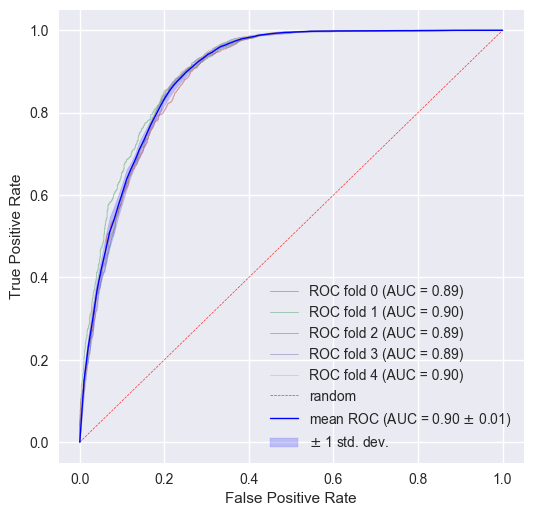

In [25]:
from sklearn.ensemble import RandomForestClassifier

parameters_grid = [
    {'n_estimators': [10, 100, 1000], 'max_depth': [5, 20, 50]}
]

model_GS_RandomForestClassifier = GridSearchCV(RandomForestClassifier(), parameters_grid, cv = inner_cv_strategy, scoring = 'roc_auc', refit = True)

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
run_model(model_GS_RandomForestClassifier, X, y, cv_strategy, grid_search = True, print_grid_search_metrics = True, print_fold_metrics = True, plot_roc = True, ax = ax)


## Mean accuracy: 0.82 ± 0.01
## Mean ROC AUC : 0.77 ± 0.01


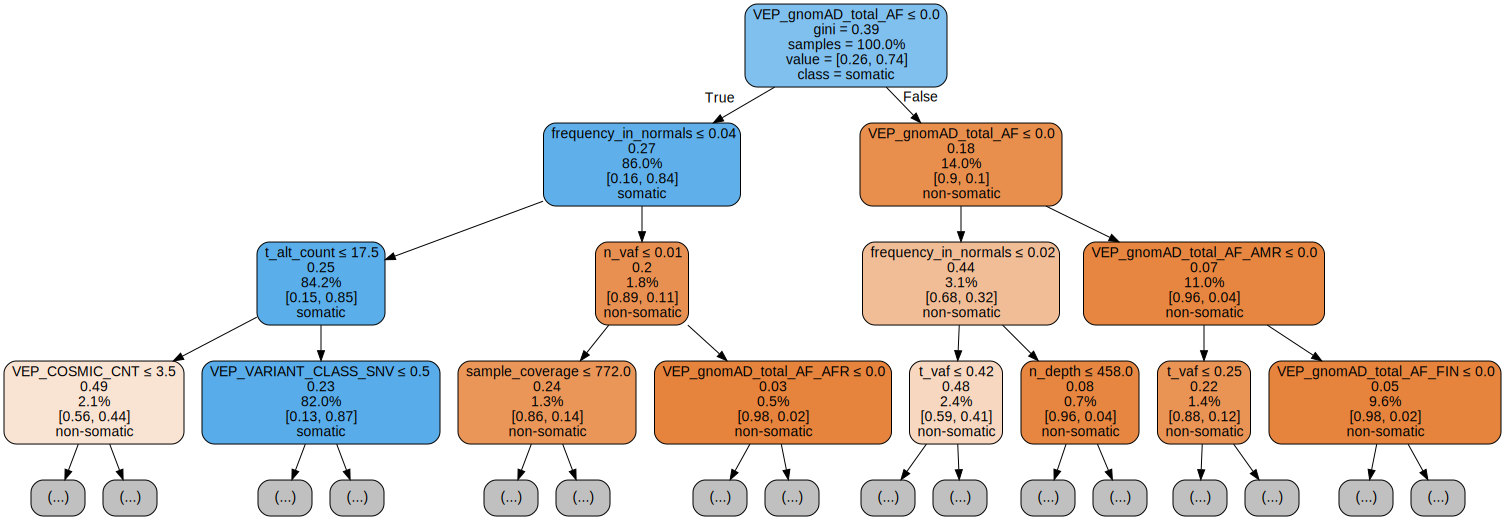

In [26]:
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz

model_DecisionTreeClassifier = DecisionTreeClassifier(random_state = 1)
run_model(model_DecisionTreeClassifier, X, y, cv_strategy)

model_DecisionTreeClassifier.fit(X, y)
dot_data = export_graphviz(model_DecisionTreeClassifier, out_file = None, max_depth = 3, feature_names = X.columns.tolist(), class_names = ['non-somatic', 'somatic'], label = 'root', filled = True, proportion = True, rounded = True, special_characters = True, precision = 2) 
graph = graphviz.Source(dot_data) 
graph

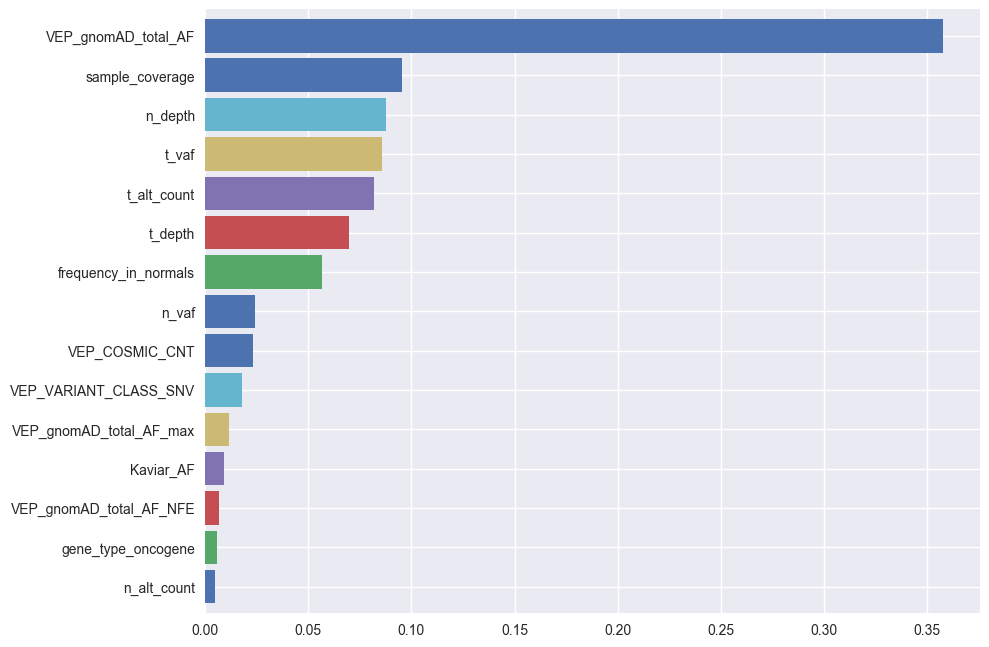

In [27]:
feature_importance = pd.Series(model_DecisionTreeClassifier.feature_importances_.tolist(), index = X.columns.tolist())
feature_importance.sort_values(inplace = True)
feature_importance = feature_importance.tail(15)
feature_importance.plot.barh(figsize = (10, 8), width = 0.85);


## Mean accuracy: 0.88 ± 0.00
## Mean ROC AUC : 0.89 ± 0.01


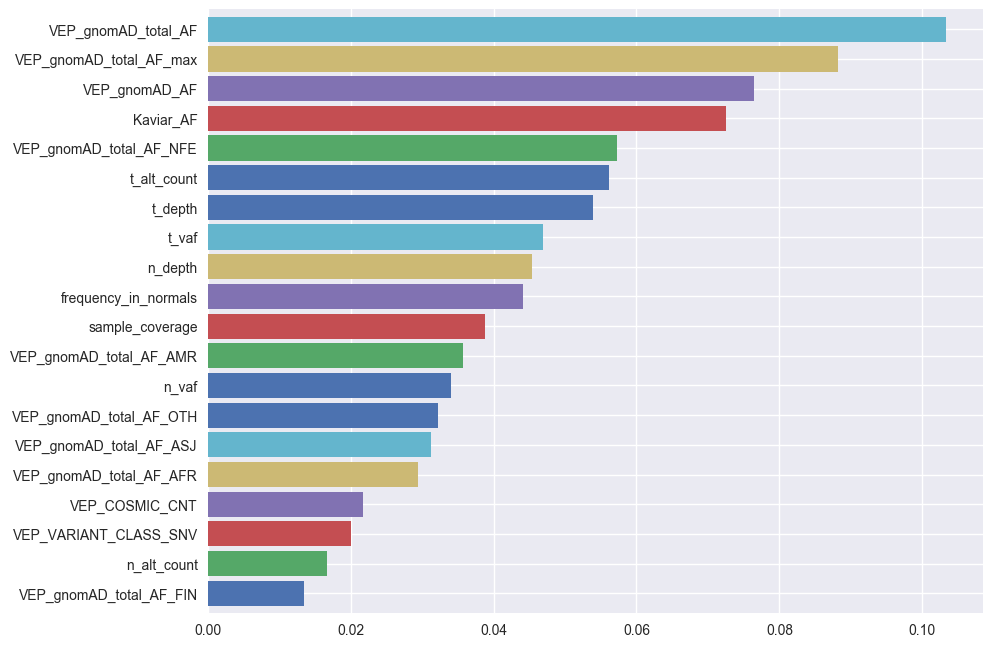

In [28]:
from sklearn.ensemble import RandomForestClassifier

model_best_RandomForestClassifier = RandomForestClassifier(random_state = 1, n_estimators = 100, max_depth = 20)
run_model(model_best_RandomForestClassifier, X, y, cv_strategy)

model_best_RandomForestClassifier.fit(X, y)

feature_importance = pd.Series(model_best_RandomForestClassifier.feature_importances_.tolist(), index = X.columns.tolist())
feature_importance.sort_values(inplace = True)
feature_importance = feature_importance.tail(20)
feature_importance.plot.barh(figsize = (10, 8), width = 0.85);

## Gradient Boosting

Fold #: [fit_time | score_time]
   → accuracy: [test_accuracy | train_accuracy]
   → ROC AUC : [test_roc_auc  | train_roc_auc]

Fold 0: [34.91s | 0.08s]
  → accuracy: [0.88 | 0.88]
  → ROC AUC : [0.88 | 0.90]
  → Best parameters : {'learning_rate': 0.1, 'n_estimators': 100}
    0.82 ± 0.01 for {'learning_rate': 0.01, 'n_estimators': 10}
    0.85 ± 0.01 for {'learning_rate': 0.01, 'n_estimators': 100}
    0.84 ± 0.00 for {'learning_rate': 0.1, 'n_estimators': 10}
    0.88 ± 0.00 for {'learning_rate': 0.1, 'n_estimators': 100}
    0.87 ± 0.01 for {'learning_rate': 1, 'n_estimators': 10}
    0.87 ± 0.01 for {'learning_rate': 1, 'n_estimators': 100}
Fold 1: [34.75s | 0.08s]
  → accuracy: [0.88 | 0.88]
  → ROC AUC : [0.90 | 0.89]
  → Best parameters : {'learning_rate': 0.1, 'n_estimators': 100}
    0.83 ± 0.01 for {'learning_rate': 0.01, 'n_estimators': 10}
    0.85 ± 0.01 for {'learning_rate': 0.01, 'n_estimators': 100}
    0.85 ± 0.01 for {'learning_rate': 0.1, 'n_estimators': 10}
    0.8

,fit_time,score_time,train_accuracy,test_accuracy,train_roc_auc,test_roc_auc,best_parameters
fold_number,,,,,,,
0,34.9126,0.0791869,0.882118,0.880331,0.896267,0.882781,"{'learning_rate': 0.1, 'n_estimators': 100}"
1,34.751,0.0789692,0.882991,0.880147,0.89475,0.895432,"{'learning_rate': 0.1, 'n_estimators': 100}"
2,34.4062,0.0763741,0.883083,0.879596,0.896355,0.880396,"{'learning_rate': 0.1, 'n_estimators': 100}"
3,35.1259,0.0756898,0.884002,0.879596,0.896101,0.886436,"{'learning_rate': 0.1, 'n_estimators': 100}"
4,33.4458,0.0784383,0.882348,0.881801,0.89522,0.889147,"{'learning_rate': 0.1, 'n_estimators': 100}"


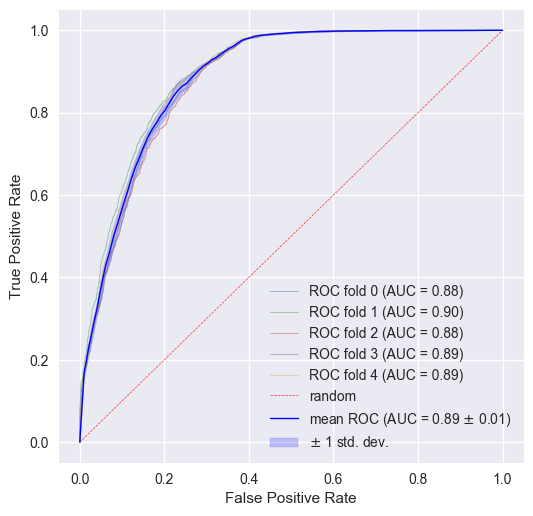

In [29]:
from sklearn.ensemble import GradientBoostingClassifier

parameters_grid = [
    {'learning_rate': [0.01, 0.1, 1], 'n_estimators': [10, 100]}
]

model_GS_GradientBoostingClassifier = GridSearchCV(GradientBoostingClassifier(random_state = 1), parameters_grid, cv = inner_cv_strategy, scoring = 'roc_auc', refit = True)

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
run_model(model_GS_GradientBoostingClassifier, X, y, cv_strategy, grid_search = True, print_grid_search_metrics = True, print_fold_metrics = True, plot_roc = True, ax = ax)


## Mean accuracy: 0.88 ± 0.00
## Mean ROC AUC : 0.89 ± 0.01


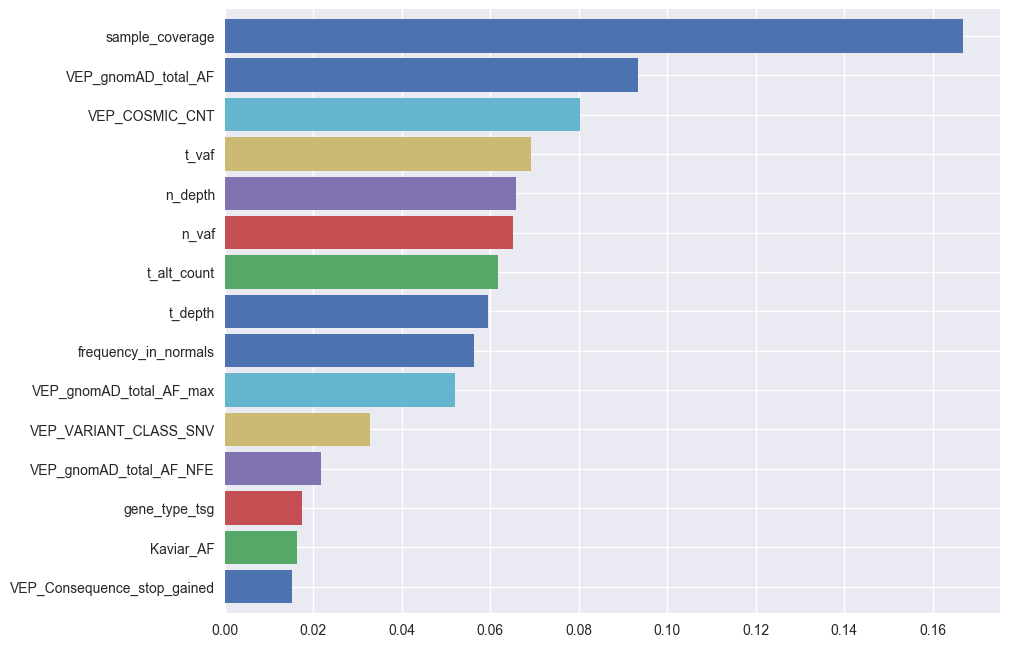

In [30]:
model_best_GradientBoostingClassifier = GradientBoostingClassifier(random_state = 1, learning_rate = 0.1, n_estimators = 100)
run_model(model_best_GradientBoostingClassifier, X, y, cv_strategy)

model_best_GradientBoostingClassifier.fit(X, y)

feature_importance = pd.Series(model_best_GradientBoostingClassifier.feature_importances_.tolist(), index = X.columns.tolist())
feature_importance.sort_values(inplace = True)
feature_importance = feature_importance.tail(15)
feature_importance.plot.barh(figsize = (10, 8), width = 0.85);

## Support Vector Machine

In [ ]:
from sklearn.svm import SVC

parameters_grid = [
    {'C': [0.1, 1, 10]}
]
#model_GS_SVC = GridSearchCV(SVC(), parameters_grid, cv = inner_cv_strategy, scoring = 'roc_auc', refit = True)
model_GS_SVC = SVC(kernel='linear', probability=True)


fig, ax = plt.subplots(1, 1, figsize = (6, 6))
run_model(model_GS_SVC, X, y, cv_strategy, grid_search = False, print_grid_search_metrics = True, print_fold_metrics = True, plot_roc = True, ax = ax)

Fold #: [fit_time | score_time]
   → accuracy: [test_accuracy | train_accuracy]
   → ROC AUC : [test_roc_auc  | train_roc_auc]



## Cluster test


## Mean accuracy: 0.80 ± 0.01
## Mean ROC AUC : 0.80 ± 0.02


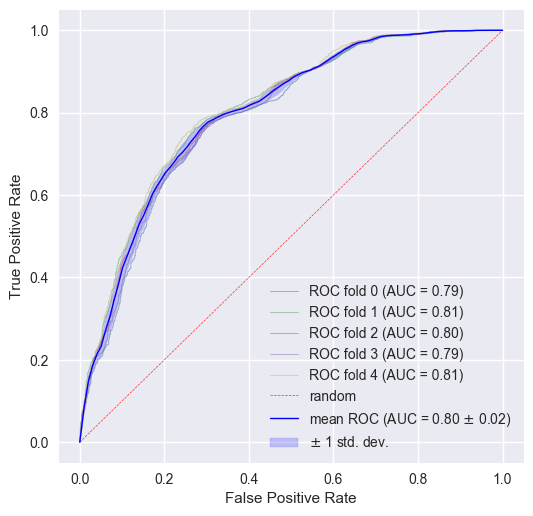

In [22]:
from sklearn.naive_bayes import GaussianNB

model_GaussianNB = GaussianNB()

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
metrics = run_model(model_GaussianNB, X, y, cv_strategy, plot_roc = True, ax = ax)

In [23]:
metrics

,fit_time,score_time,train_accuracy,test_accuracy,train_roc_auc,test_roc_auc,best_parameters
fold_number,,,,,,,
0,0.10051,0.0498331,0.797739,0.799816,0.79922,0.788132,NaN
1,0.071846,0.0409212,0.795119,0.795404,0.798381,0.806598,NaN
2,0.0685248,0.0434558,0.793511,0.79761,0.79502,0.799848,NaN
3,0.0704761,0.0416601,0.796498,0.800735,0.796747,0.793025,NaN
4,0.0697663,0.0497072,0.79875,0.807169,0.798306,0.80942,NaN


In [24]:
metrics.to_csv("~/Desktop/temp/job_1234/metrics.csv")

In [61]:
def get_job_result(job_id):
    path = "~/Desktop/temp/job_" + str(job_id) + "/metrics.csv"
    
    file_found = ! [ -e $path ] && echo "yes" || echo "no"
    file_found = file_found[0]
    
    try:
        if file_found == "yes":
            return pd.read_csv(path, sep = ',', low_memory = False)
        else:
            raise Exception("⚠️ <span style='color:red'>Job " + str(job_id) + " doesn't exist or not done yet.</span>\n")

    except Exception as e:
        print_md(str(e))
        
get_job_result(1234)

,fold_number,fit_time,score_time,train_accuracy,test_accuracy,train_roc_auc,test_roc_auc,best_parameters
0,0,0.100510,0.049833,0.797739,0.799816,0.799220,0.788132,NaN
1,1,0.071846,0.040921,0.795119,0.795404,0.798381,0.806598,NaN
2,2,0.068525,0.043456,0.793511,0.797610,0.795020,0.799848,NaN
3,3,0.070476,0.041660,0.796498,0.800735,0.796747,0.793025,NaN
4,4,0.069766,0.049707,0.798750,0.807169,0.798306,0.809420,NaN


In [64]:
! ssh guilminp@selene.mskcc.org 'source ~/.bash_profile;bsub -I -We 20 "echo test"'

Hi Pierre!
Sep 28 10:25:22 2018 13345 3 1.2.10 lsb_init: initenv_:fopen(/etc/lsf.conf) failed, No such file or directory.
lsb_init: Failed in an LSF library call: Unable to open file lsf.conf. Job not submitted.


In [8]:
! ssh guilminp@selene.mskcc.org 'ls'

impact-annotator
R
synonymous_mutations_analysis_extra
synonymous_mutations_analysis_extra_TP53
test


In [19]:
! python3 -c 'from ml_tools import *;\
from sklearn.naive_bayes import GaussianNB;\
model_GaussianNB = GaussianNB();\
X, y, cv_strategy = load_dataset();\
run_model(model_GaussianNB, X, y, cv_strategy, print_fold_metrics = True)'

/Users/pierreguilmin/anaconda3/envs/impact-annotator_env/lib/python3.6/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
Fold #: [fit_time | score_time]
   → accuracy: [test_accuracy | train_accuracy]
   → ROC AUC : [test_roc_auc  | train_roc_auc]

Fold 0: [0.11s | 0.05s]
  → accuracy: [0.80 | 0.80]
  → ROC AUC : [0.79 | 0.80]
Fold 1: [0.08s | 0.05s]
  → accuracy: [0.80 | 0.80]
  → ROC AUC : [0.81 | 0.80]
Fold 2: [0.10s | 0.04s]
  → accuracy: [0.80 | 0.79]
  → ROC AUC : [0.80 | 0.80]
Fold 3: [0.09s | 0.05s]
  → accuracy: [0.80 | 0.80]
  → ROC AUC : [0.79 | 0.80]
Fold 4: [0.10s | 0.05s]
  → accuracy: [0.81 | 0.80]
  → ROC AUC : [0.81 | 0.80]

## Mean accuracy: 0.80 ± 0.01
## Mean ROC AUC : 0.80 ± 0.02


In [54]:
! python3 -c """from ml_tools import *;\
from sklearn.dummy import DummyClassifier;\
model_most_frequent = DummyClassifier(strategy = "most_frequent", random_state = 1);\
X, y, cv_strategy = load_dataset();\
run_model(model_most_frequent, X, y, cv_strategy, print_fold_metrics = True)"""

/Users/pierreguilmin/anaconda3/envs/impact-annotator_env/lib/python3.6/site-packages/sklearn/externals/joblib/externals/cloudpickle/cloudpickle.py:47: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  import imp
Fold #: [fit_time | score_time]
   → accuracy: [test_accuracy | train_accuracy]
   → ROC AUC : [test_roc_auc  | train_roc_auc]

Fold 0: [0.00s | 0.01s]
  → accuracy: [0.74 | 0.74]
  → ROC AUC : [0.50 | 0.50]
Fold 1: [0.00s | 0.02s]
  → accuracy: [0.74 | 0.74]
  → ROC AUC : [0.50 | 0.50]
Fold 2: [0.00s | 0.01s]
  → accuracy: [0.74 | 0.74]
  → ROC AUC : [0.50 | 0.50]
Fold 3: [0.00s | 0.01s]
  → accuracy: [0.74 | 0.74]
  → ROC AUC : [0.50 | 0.50]
Fold 4: [0.00s | 0.01s]
  → accuracy: [0.74 | 0.74]
  → ROC AUC : [0.50 | 0.50]

## Mean accuracy: 0.74 ± 0.00
## Mean ROC AUC : 0.50 ± 0.00


In [65]:
! ssh guilminp@selene.mskcc.org 'python -c "import os;\
print(os.getcwd()) "'

/home/guilminp


In [103]:
! ssh guilminp@selene.mskcc.org 'source ~/.bash_profile;\
bsub -We 20 echo "test"'

Hi Pierre!
Sep 27 17:18:14 2018 36593 3 1.2.10 lsb_init: initenv_:fopen(/etc/lsf.conf) failed, No such file or directory.
lsb_init: Failed in an LSF library call: Unable to open file lsf.conf. Job not submitted.


In [100]:
! ssh guilminp@selene.mskcc.org '\
\
cd impact-annotator/analysis/prediction;\
source ~/.bash_profile;\
workon impact-annotator_env;\
python -c "\
from ml_tools import *;\
from sklearn.dummy import DummyClassifier;\
model_most_frequent = DummyClassifier(strategy = \"most_frequent\", random_state = 1);\
X, y, cv_strategy = load_dataset();\
run_model(model_most_frequent, X, y, cv_strategy, print_fold_metrics = True)\
"\
\'

Hi Pierre!
Fold #: [fit_time | score_time]
   → accuracy: [test_accuracy | train_accuracy]
   → ROC AUC : [test_roc_auc  | train_roc_auc]

Fold 0: [0.00s | 0.01s]
  → accuracy: [0.74 | 0.74]
  → ROC AUC : [0.50 | 0.50]
Fold 1: [0.00s | 0.01s]
  → accuracy: [0.74 | 0.74]
  → ROC AUC : [0.50 | 0.50]
Fold 2: [0.00s | 0.01s]
  → accuracy: [0.74 | 0.74]
  → ROC AUC : [0.50 | 0.50]
Fold 3: [0.00s | 0.01s]
  → accuracy: [0.74 | 0.74]
  → ROC AUC : [0.50 | 0.50]
Fold 4: [0.00s | 0.01s]
  → accuracy: [0.74 | 0.74]
  → ROC AUC : [0.50 | 0.50]

## Mean accuracy: 0.74 ± 0.00
## Mean ROC AUC : 0.50 ± 0.00


In [ ]:
from sklearn.naive_bayes import GaussianNB

model_GaussianNB = GaussianNB()

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
run_model(model_GaussianNB, X, y, cv_strategy, plot_roc = True, ax = ax)

In [4]:
! ssh guilminp@selene.mskcc.org '/ifs/work/leukgen/bin/python/.virtualenvs/isabel3.6/bin/ipython'

]0;IPython: home/guilminpPython 3.6.4 (default, Jan 23 2018, 11:51:27) 
Type 'copyright', 'credits' or 'license' for more information
IPython 6.3.1 -- An enhanced Interactive Python. Type '?' for help.

In [1]: ^C


In [ ]:
from sklearn.dummy import DummyClassifier

model_most_frequent = DummyClassifier(strategy = 'most_frequent', random_state = 1)
# always predicts the most frequent label in the training set
#   → expected accuracy: proportion of the most reccurent class in the dataset | expected AUC: 0.5

fig, ax = plt.subplots(1, 1, figsize = (6, 6))
run_model(model_most_frequent, X, y, cv_strategy, plot_roc = True, ax = ax)

## Other

In [ ]:
from sklearn.model_selection import learning_curve
train_sizes, train_scores, test_scores = learning_curve(model, X, y, train_sizes = np.linspace(0.1, 1.0, 5), cv = 5)

for i in range(n_folds):
    plt.plot(train_sizes, train_scores[i], linewidth = 0.5, alpha = 0.4, color = 'r',
                     label = 'training score fold %d' % i)
    plt.plot(train_sizes, test_scores[i], linewidth = 0.5, alpha = 0.4, color = 'g',
                     label = 'test score fold %d' % i)
    
train_scores_mean = np.mean(train_scores, axis = 0)
train_scores_std = np.std(train_scores, axis = 0)
test_scores_mean = np.mean(test_scores, axis = 0)
test_scores_std = np.std(test_scores, axis = 0)

plt.plot(train_sizes, train_scores_mean, 'o-r', linewidth = 1,
        label = 'mean training score')
plt.plot(train_sizes, test_scores_mean, 'o-g', linewidth = 1,
         label = 'mean test score')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha = 0.1, color = 'r')
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha = 0.1, color = 'g')


plt.xlabel("Training size")
plt.ylabel("Accuracy score")
plt.legend(loc = "lower right", prop = {'size': 5})

Gradient boosting